# 119-1 e 119-2 BGE Large v1.5

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\msanto22\AppData\Local\Temp\ipykernel_24360\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Sentence Transformers

### BGE Large v1.5

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np

C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Carregar modelo e tokenizer do BGE Large 1.5

model_name = 'BAAI/bge-large-en-v1.5'  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [4]:
# Função para pooling médio
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # Primeiro elemento contém os embeddings dos tokens
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Funções para gerar os vetores de embeddings
def gerar_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        model_output = model(**inputs)
        # Aplicar pooling médio e normalizar
        sentence_embedding = mean_pooling(model_output, inputs['attention_mask'])
        return sentence_embedding[0].numpy()

def gerar_embeddings_com_hierarquia(json_data, path=''):
    embeddings_hierarquicos = {}
    for chave, valor in json_data.items():
        novo_caminho = f"{path}/{chave}" if path else chave
        if isinstance(valor, dict):
            embeddings_hierarquicos.update(gerar_embeddings_com_hierarquia(valor, novo_caminho))
        elif isinstance(valor, list):
            for texto in valor:
                embedding = gerar_embedding(texto)
                embeddings_hierarquicos[novo_caminho] = embedding
        elif isinstance(valor, str):
            embedding = gerar_embedding(valor)
            embeddings_hierarquicos[novo_caminho] = embedding
    return embeddings_hierarquicos


In [5]:
# Carregar e combinar múltiplos JSONs
def carregar_e_combinar_jsons(*nomes_arquivos, diretorio='idx-07-dimep-JSON'):
    dados_combinados = {}
    for nome_arquivo in nomes_arquivos:
        caminho_completo = f"{diretorio}/{nome_arquivo}.json"
        with open(caminho_completo, 'r', encoding='utf-8') as file:
            dados = json.load(file)
            dados_combinados.update(dados)
    return dados_combinados

# Carregar e combinar os dados dos arquivos JSON
json_data = carregar_e_combinar_jsons('119-1', '119-2')


In [6]:
# Gerar embeddings
embeddings_hierarquicos = gerar_embeddings_com_hierarquia(json_data)

# Salvar os embeddings
np.save('embeddings_sentence_transformers_119-1_119-2_bge-large-v15.npy', embeddings_hierarquicos)


## Validação dos Embeddings

In [7]:
# Carregar os embeddings
embeddings = np.load('embeddings_sentence_transformers_119-1_119-2_bge-large-v15.npy', allow_pickle=True)

# Verificar o tipo do objeto carregado
print("Tipo do objeto carregado:", type(embeddings))

# Se for um dicionário ou uma lista, tentar imprimir uma parte dele
if isinstance(embeddings, dict):
    print("Alguns embeddings (chave e vetor):")
    for key in list(embeddings.keys())[:1000]:
        print(key, embeddings[key])
elif isinstance(embeddings, list):
    print("Todos os elementos da lista:", embeddings[:1000])
else:
    print("Conteúdo do objeto:", embeddings)


Tipo do objeto carregado: <class 'numpy.ndarray'>
Conteúdo do objeto: {'Travelers Cheques American Express - TC AMEX/Venda': array([-0.6506321 , -0.03422106,  0.45736128, ..., -0.587369  ,
       -0.42119548, -0.03731205], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Compra': array([-0.5194182 ,  0.47650886,  0.20356557, ..., -0.10815283,
        0.06262217, -0.6222609 ], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Reembolso': array([-0.29272023, -0.17700869, -0.14706832, ..., -0.00787464,
       -0.6145664 , -0.51555645], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Vendas': array([-0.5093788 ,  0.3886698 ,  0.34452942, ..., -0.45180526,
       -0.5889257 , -0.15311089], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': array([-0.3721126 ,  0.5031048 ,  0.14853136, ..., -0.7056666 ,
       -0.5219113 , -0.10889877], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': array([-0

In [8]:
# Verificar alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}, Tipo - {embedding.dtype}")
    print(embedding, "\n")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,), Tipo - float32
[-0.6506321  -0.03422106  0.45736128 ... -0.587369   -0.42119548
 -0.03731205] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,), Tipo - float32
[-0.5194182   0.47650886  0.20356557 ... -0.10815283  0.06262217
 -0.6222609 ] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,), Tipo - float32
[-0.29272023 -0.17700869 -0.14706832 ... -0.00787464 -0.6145664
 -0.51555645] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,), Tipo - float32
[-0.5093788   0.3886698   0.34452942 ... -0.45180526 -0.5889257
 -0.15311089] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,), Tipo - float32
[-0.3721126   0.5031048   0.14853136 ... -0.7056666  -0.5219113
 -0.10889877] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Verificar a forma de alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular': Shape - (1024,)
Embedding para 'Amex - Conferência de Estoque/Agências e PSO/SOP': Shape - (1024,)
Embedding para 'Amex - Extravio/Agências': Shape - (1024,)
Embedding para 'Amex - Destruição/Agências': Shape - (1024,)
Embedding para 'Amex - Free Exchange/Agên

In [10]:
# Achatar os embeddings para 1D se eles forem 2D
flattened_embeddings = [embeddings.item()[key].flatten() for key in embeddings.item().keys()]

# Convertendo de volta para array NumPy
flattened_embeddings = np.array(flattened_embeddings)

# Obter o número total de embeddings
n_samples = len(flattened_embeddings)

# Ajustar a perplexidade para um valor adequado
perplexity = max(5, min(n_samples - 1, 1000))  # Definindo um limite mínimo de 5

In [11]:
# Verificação Simples dos Embeddings

for embedding in flattened_embeddings[:1000]:
    print("Média:", np.mean(embedding))
    print("Desvio padrão:", np.std(embedding), "\n")


Média: -0.0030363225
Desvio padrão: 0.51967263 

Média: -0.002975802
Desvio padrão: 0.5276389 

Média: -0.0022033956
Desvio padrão: 0.52528155 

Média: -0.0030004093
Desvio padrão: 0.52741086 

Média: -0.0029935734
Desvio padrão: 0.524207 

Média: -0.0022515096
Desvio padrão: 0.54545194 

Média: -0.0033222865
Desvio padrão: 0.5204555 

Média: -0.0033260044
Desvio padrão: 0.5161929 

Média: -0.0030504456
Desvio padrão: 0.51915014 

Média: -0.003425328
Desvio padrão: 0.51790893 

Média: -0.0031318879
Desvio padrão: 0.52279365 

Média: -0.0032646619
Desvio padrão: 0.5247569 

Média: -0.0029758075
Desvio padrão: 0.5255479 

Média: -0.0029935632
Desvio padrão: 0.52264833 

Média: -0.0032258825
Desvio padrão: 0.5178774 

Média: -0.0027103284
Desvio padrão: 0.53381515 

Média: -0.0024788957
Desvio padrão: 0.53880006 



<hr>

# 1º Gráfico: Sentence Transformers (RoBERTa)
# 2º Gráfico: Sentence Transformers (BGE Large v1.5)

Text(0, 0.5, 'Componente 2')

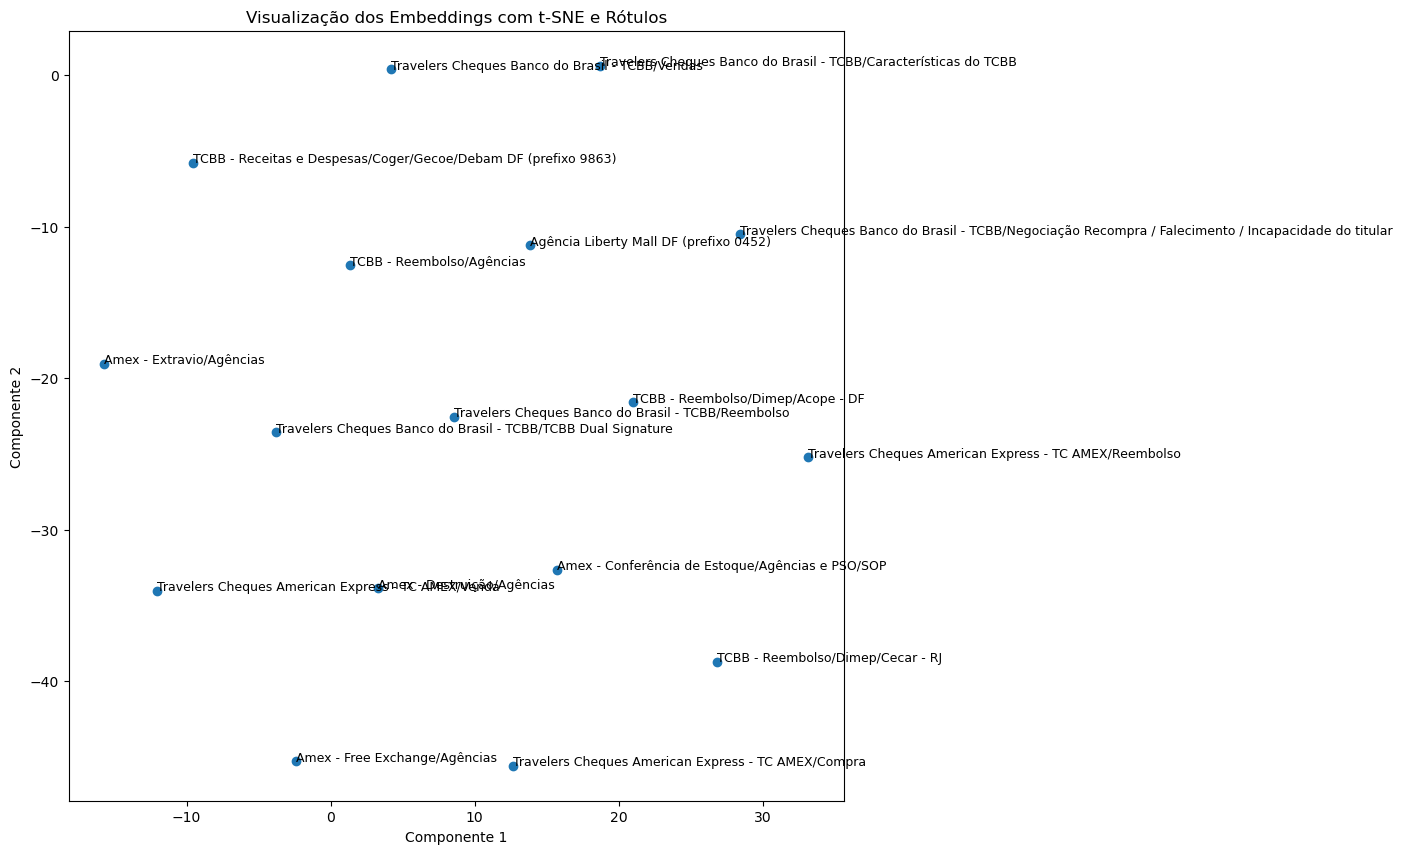

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com t-SNE e Rótulos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")


Text(0, 0.5, 'Componente 2')

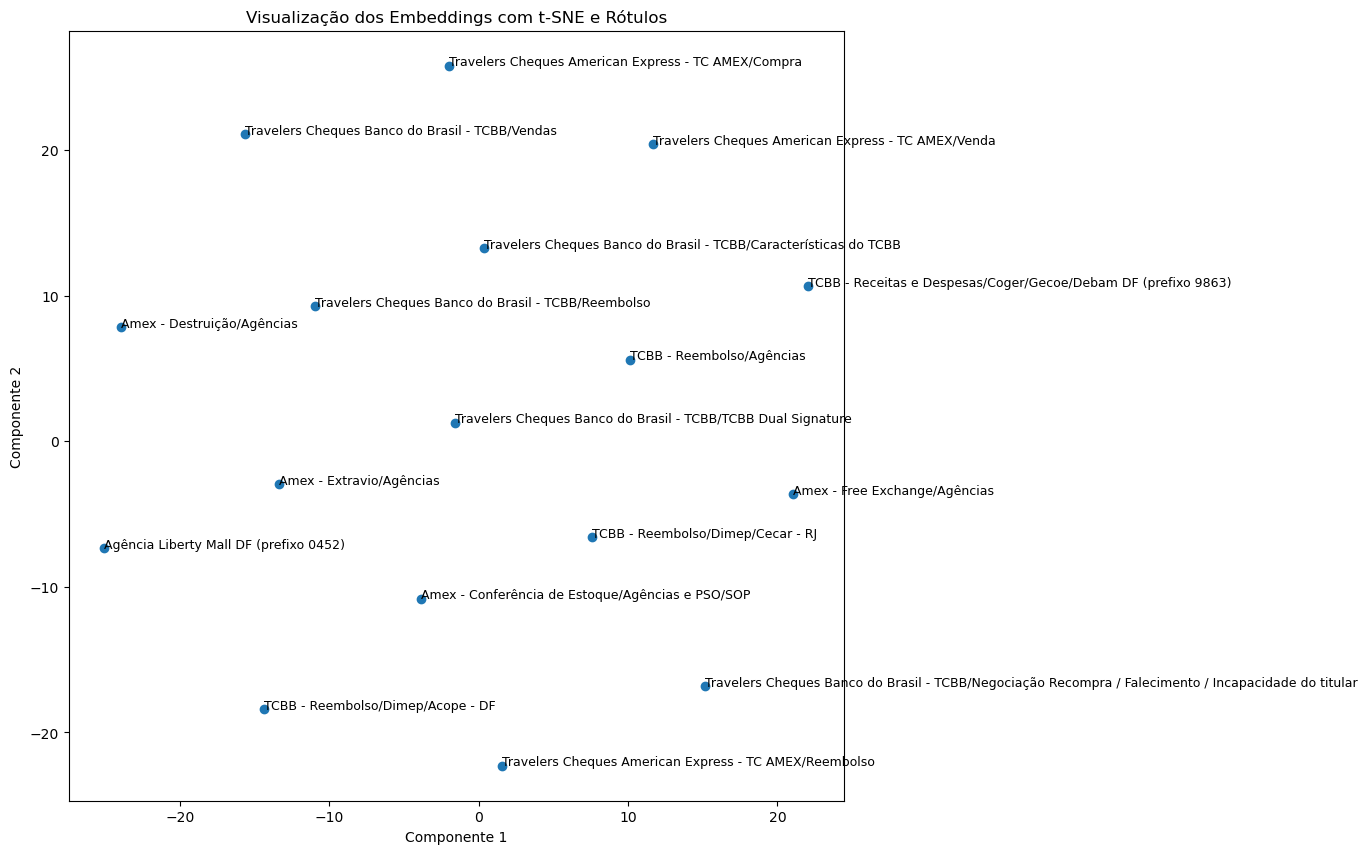

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com t-SNE e Rótulos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")


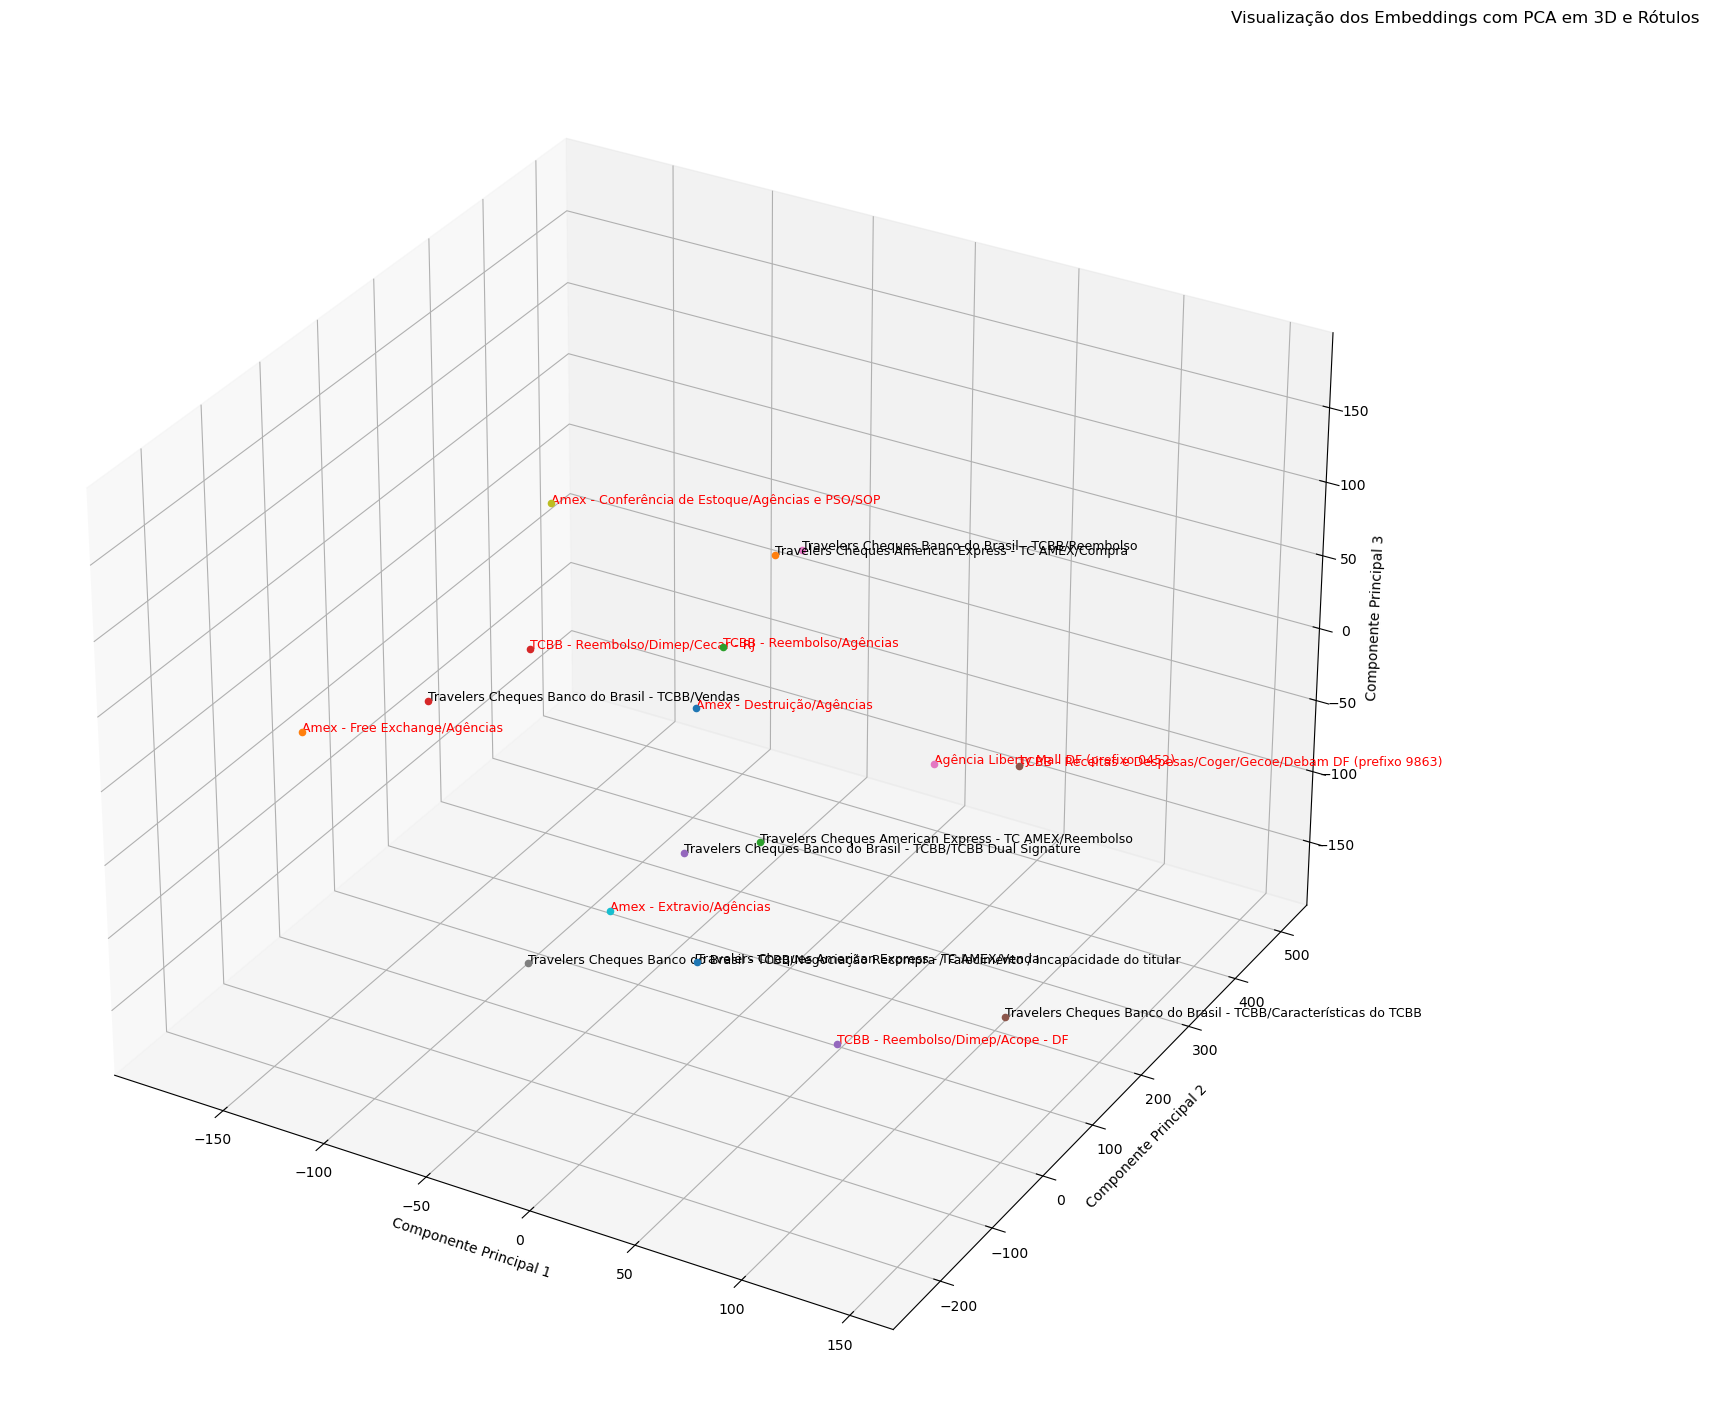

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_3d = TSNE(n_components=3, perplexity=perplexity).fit_transform(flattened_embeddings)

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]


# Iterar sobre os embeddings
for i in range(embeddings_3d.shape[0]):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i <= 7:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], fontsize=9)        
    else:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], color='red', fontsize=9)

        
ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([1.05, 0.2])


# Ajustar a posição do título para evitar o corte
ax.title.set_position([1.05, 0.2])  # Ajuste conforme necessário

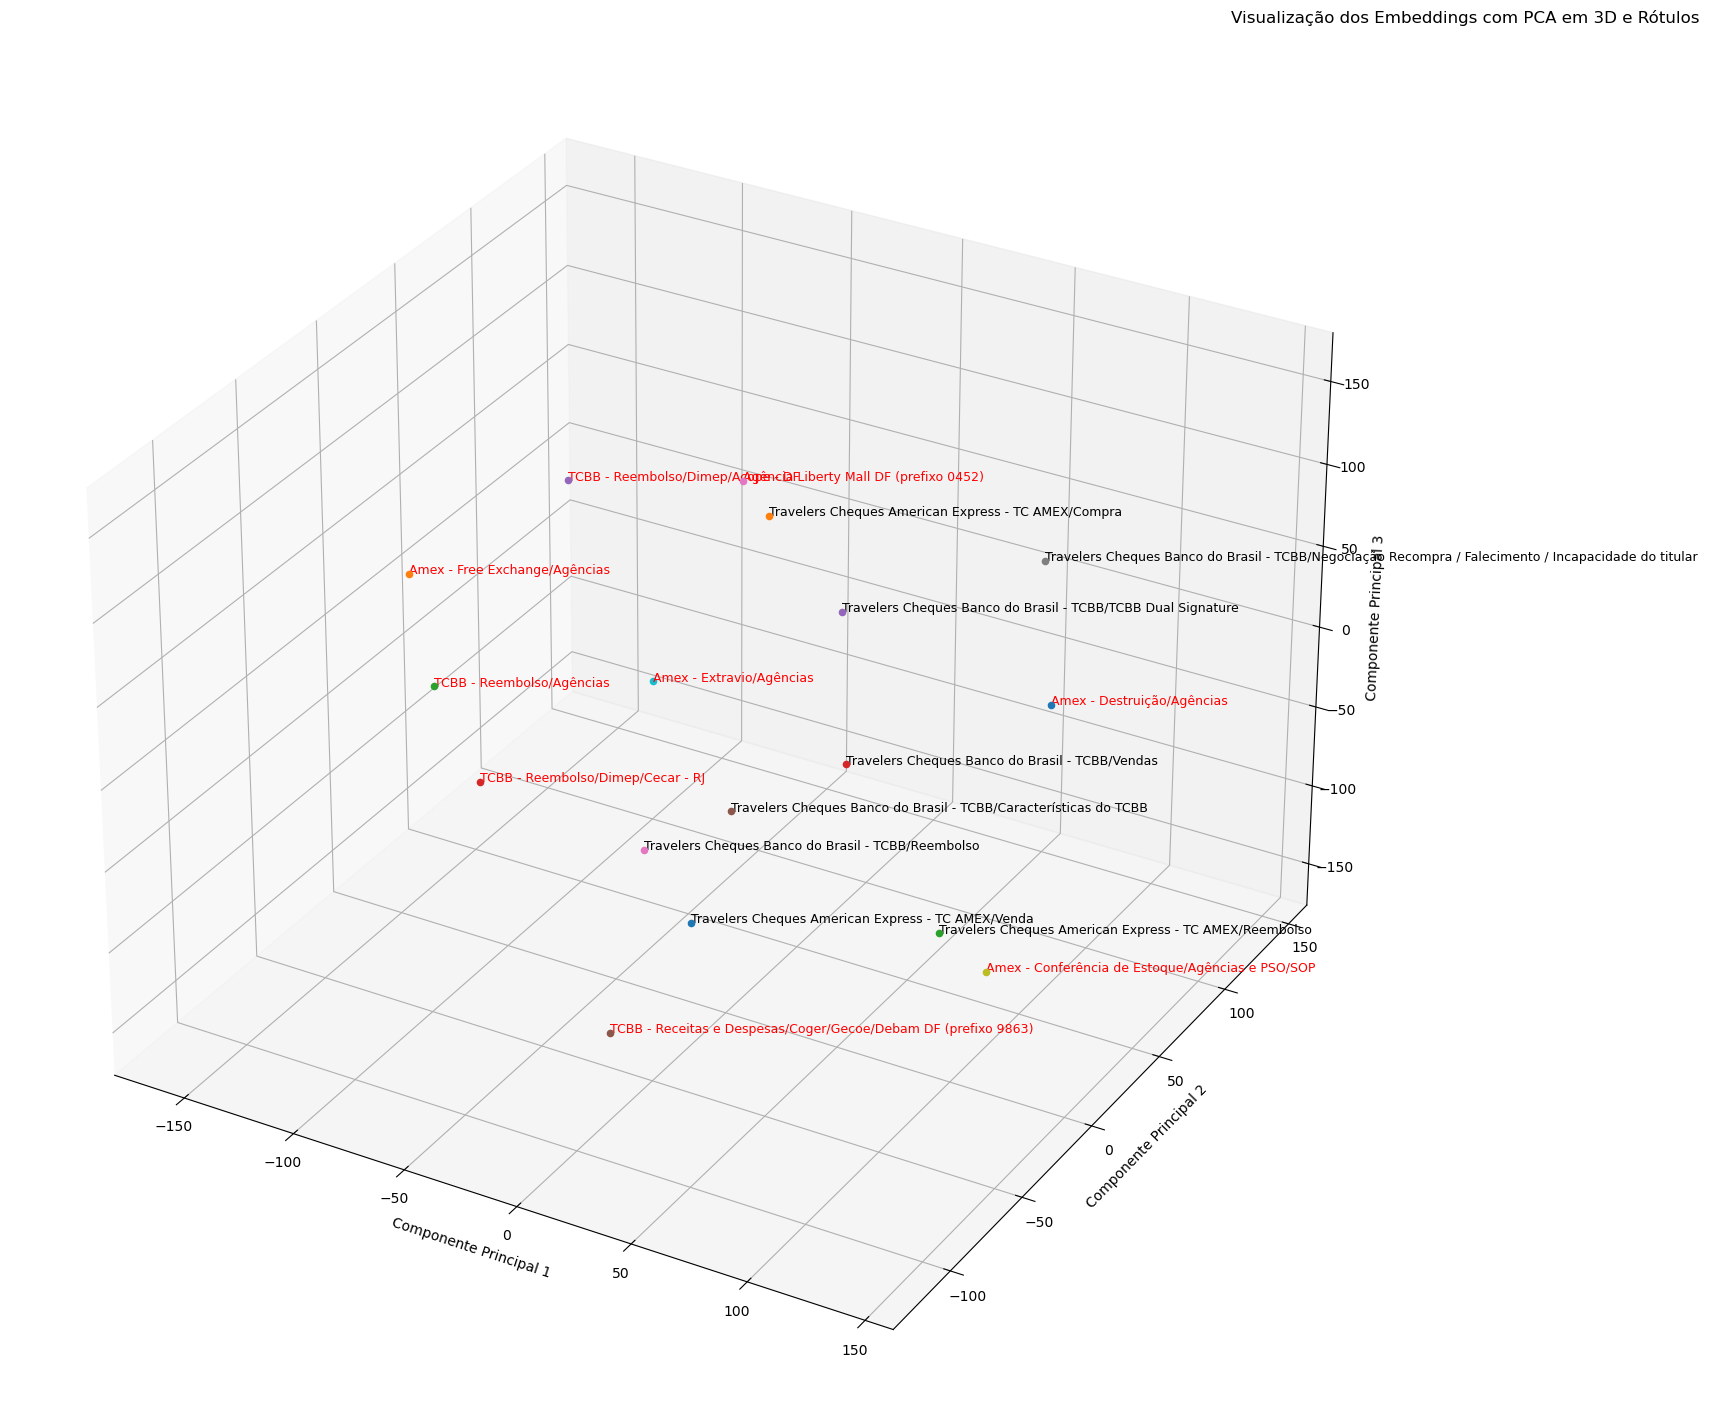

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_3d = TSNE(n_components=3, perplexity=perplexity).fit_transform(flattened_embeddings)

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]


# Iterar sobre os embeddings
for i in range(embeddings_3d.shape[0]):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i <= 7:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], fontsize=9)        
    else:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], color='red', fontsize=9)

        
ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([1.05, 0.2])


# Ajustar a posição do título para evitar o corte
ax.title.set_position([1.05, 0.2])  # Ajuste conforme necessário

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Supondo que `embeddings_3d` seja a sua matriz de embeddings após aplicar t-SNE e contenha 8 vetores
# Calcular a similaridade de cosseno entre esses 9 embeddings
similarity_matrix = cosine_similarity(embeddings_3d)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno:")
print(similarity_matrix)


Matriz de Similaridade de Cosseno:
[[ 0.99999994 -0.9996444   0.04360007  0.6944794  -0.7740501  -0.6798903
  -0.16258137 -0.00649361  0.6697292   0.70348096 -0.62133867  0.13285945
  -0.58191913  0.4300768  -0.6469806   0.6833902  -0.08141512]
 [-0.9996444   0.99999994 -0.05612155 -0.6813276   0.788385    0.661604
   0.13626604  0.03040229 -0.6707107  -0.6882166   0.6206011  -0.12553671
   0.56728184 -0.43988842  0.65506667 -0.702466    0.10568006]
 [ 0.04360007 -0.05612155  1.          0.27206147 -0.01172649  0.5375463
   0.510818   -0.03179725  0.7040674  -0.61634207  0.672499   -0.96241874
  -0.3060287  -0.52997833 -0.78819704  0.44961238 -0.7881267 ]
 [ 0.6944794  -0.6813276   0.27206147  1.         -0.10348841 -0.6492739
  -0.55631506  0.6650949   0.83760643  0.5301689  -0.0238364  -0.28299367
  -0.98924476 -0.31973198 -0.66884047  0.17178383  0.16924365]
 [-0.7740501   0.788385   -0.01172649 -0.10348841  1.          0.24509895
  -0.3939383   0.63674337 -0.30833638 -0.37358394  0

Text(0.5, 1.0, 'Heatmap da Similaridade de Cosseno t-SNE')

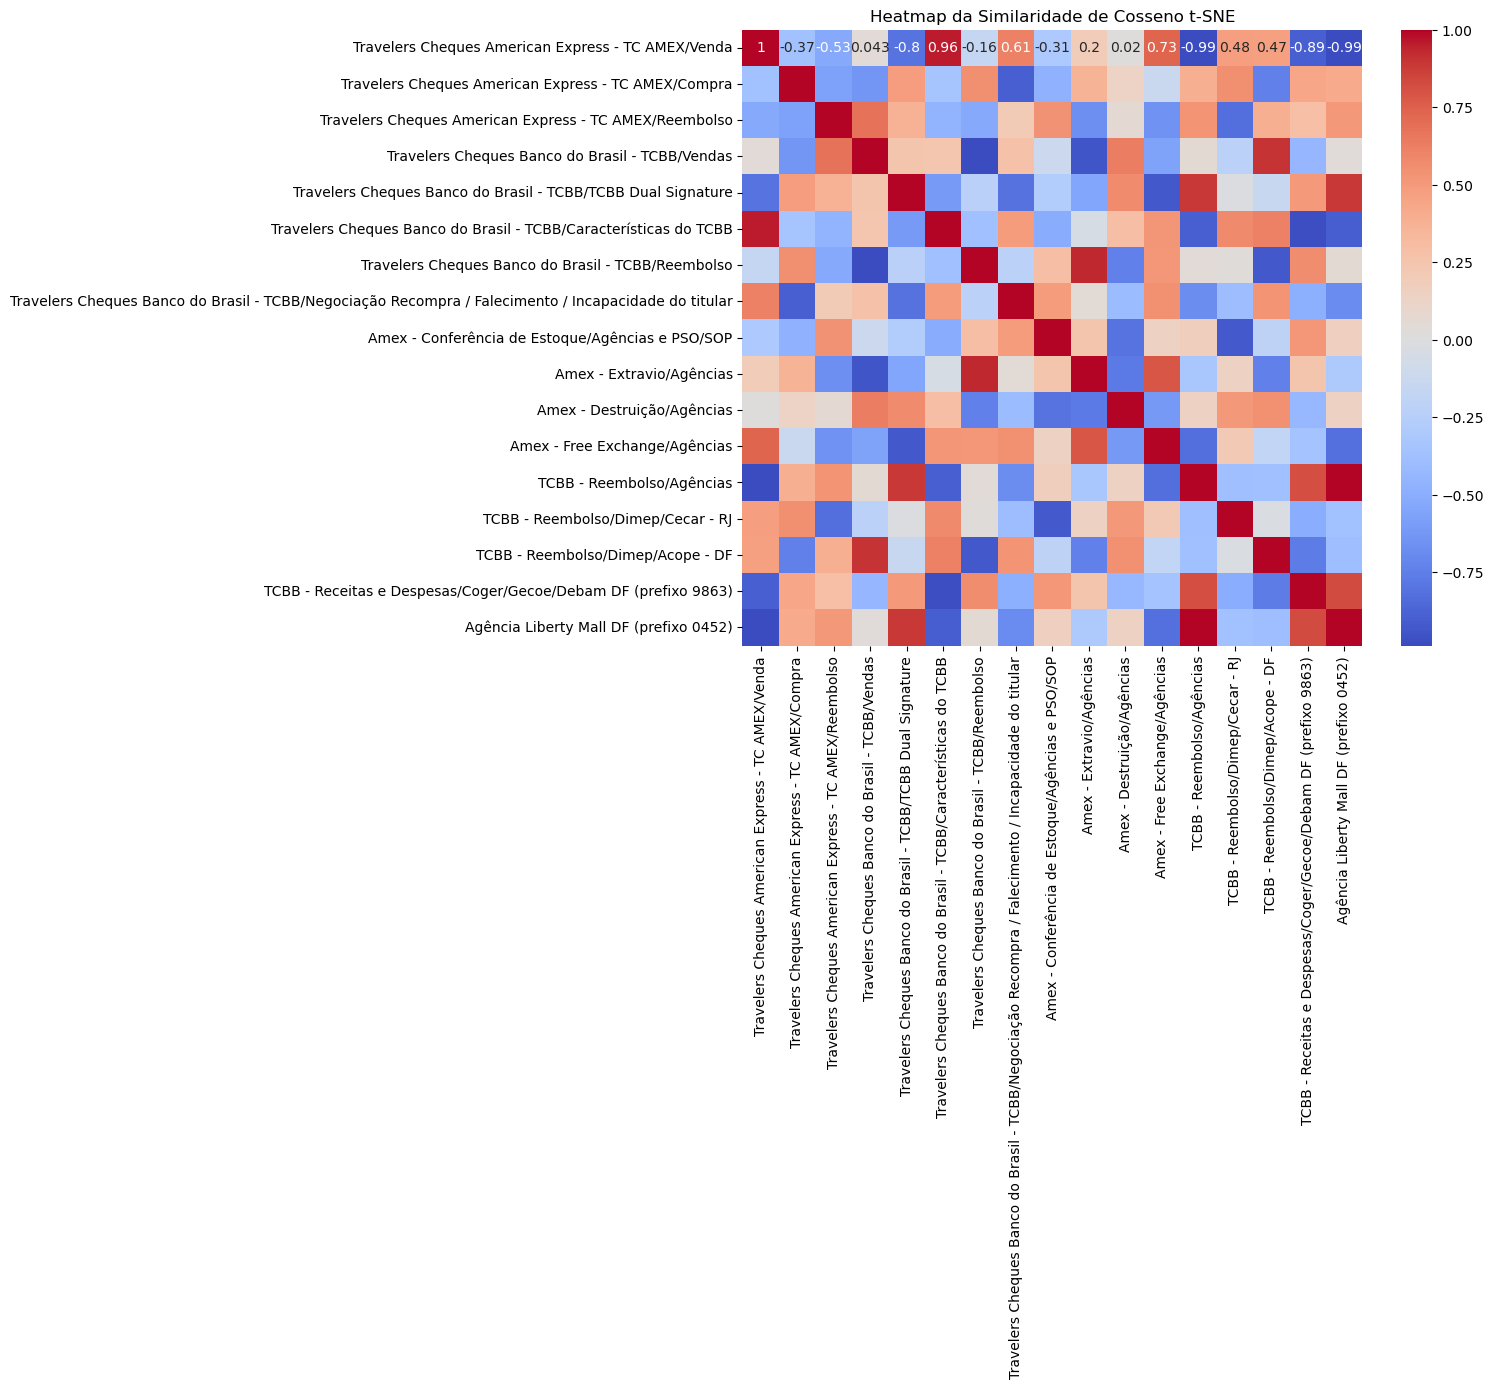

In [15]:
Sentence Transformers (RoBERTa)import seaborn as sns

# Heatmap da matriz de similaridade de cosseno para os 9 embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno t-SNE")


Text(0.5, 1.0, 'Heatmap da Similaridade de Cosseno t-SNE')

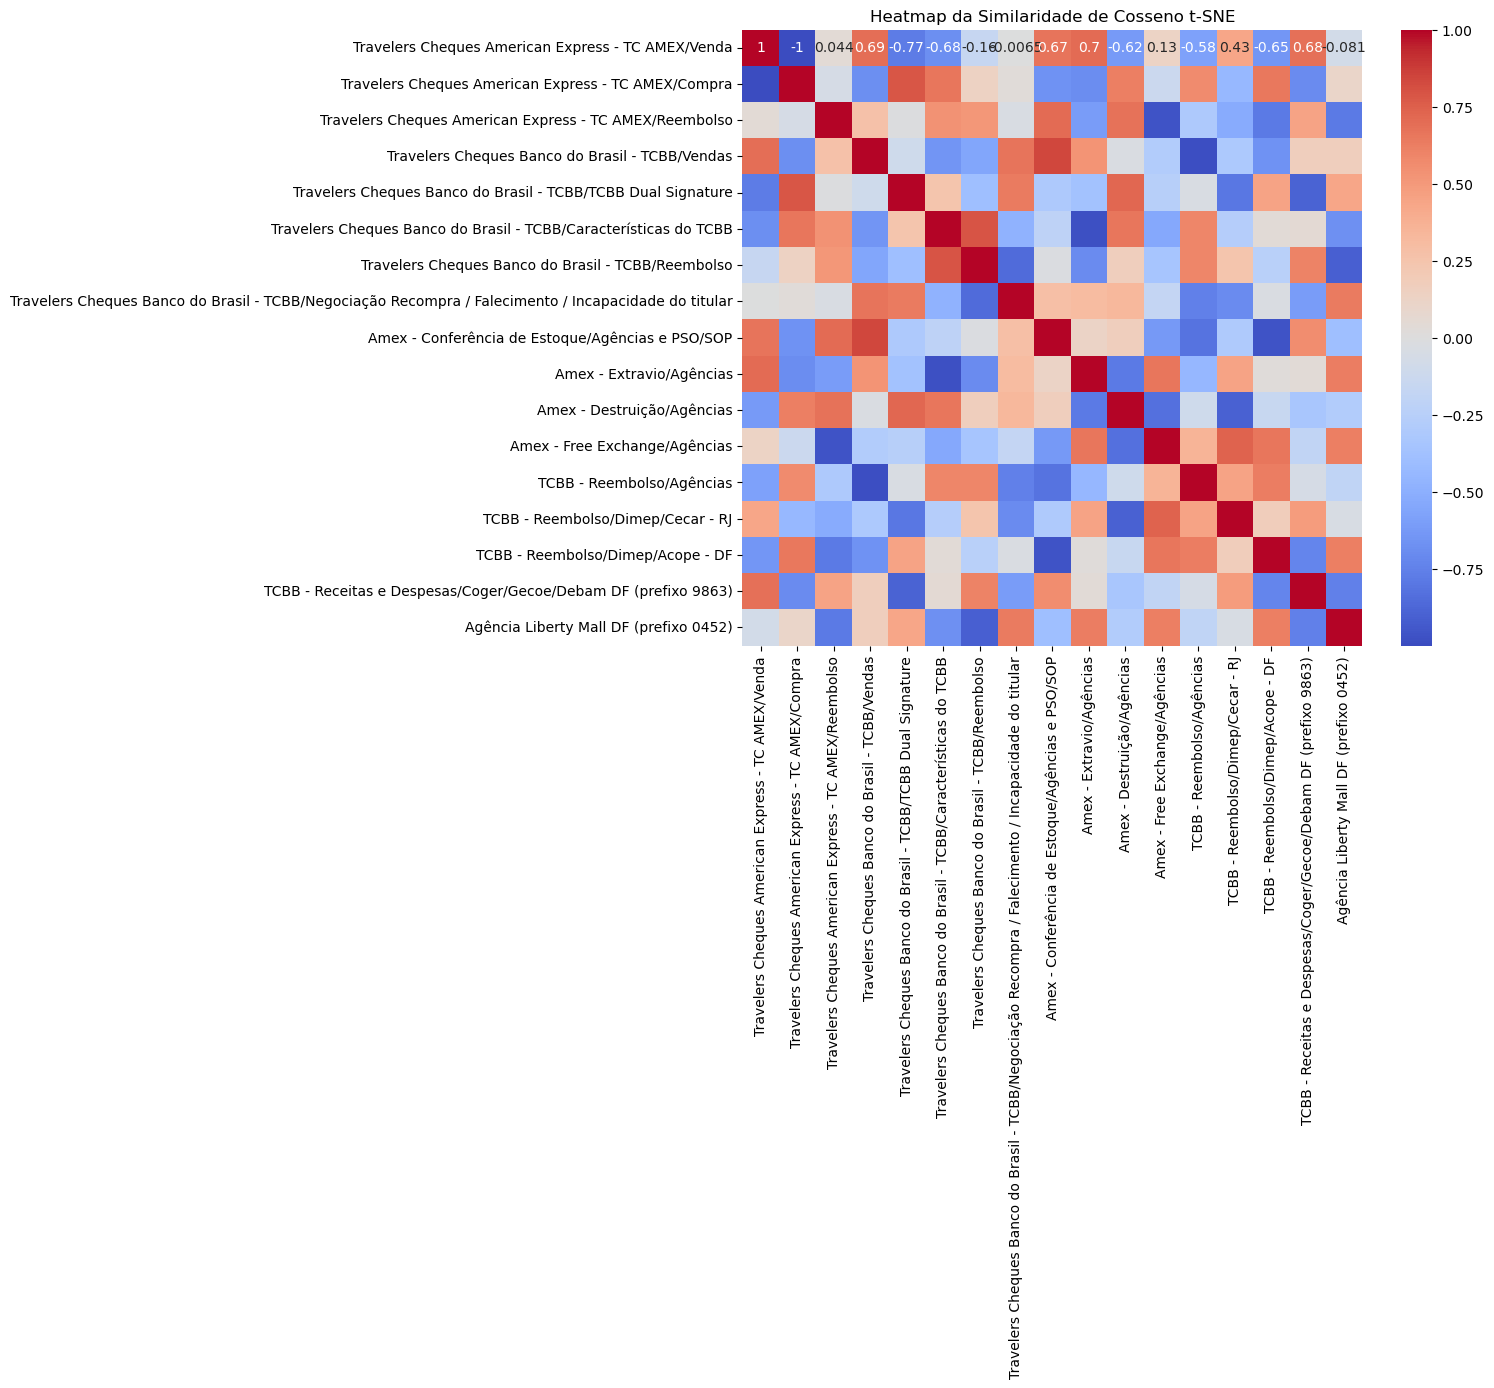

In [15]:
import seaborn as sns

# Heatmap da matriz de similaridade de cosseno para os 9 embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno t-SNE")


Text(0, 0.5, 'Componente Principal 2')

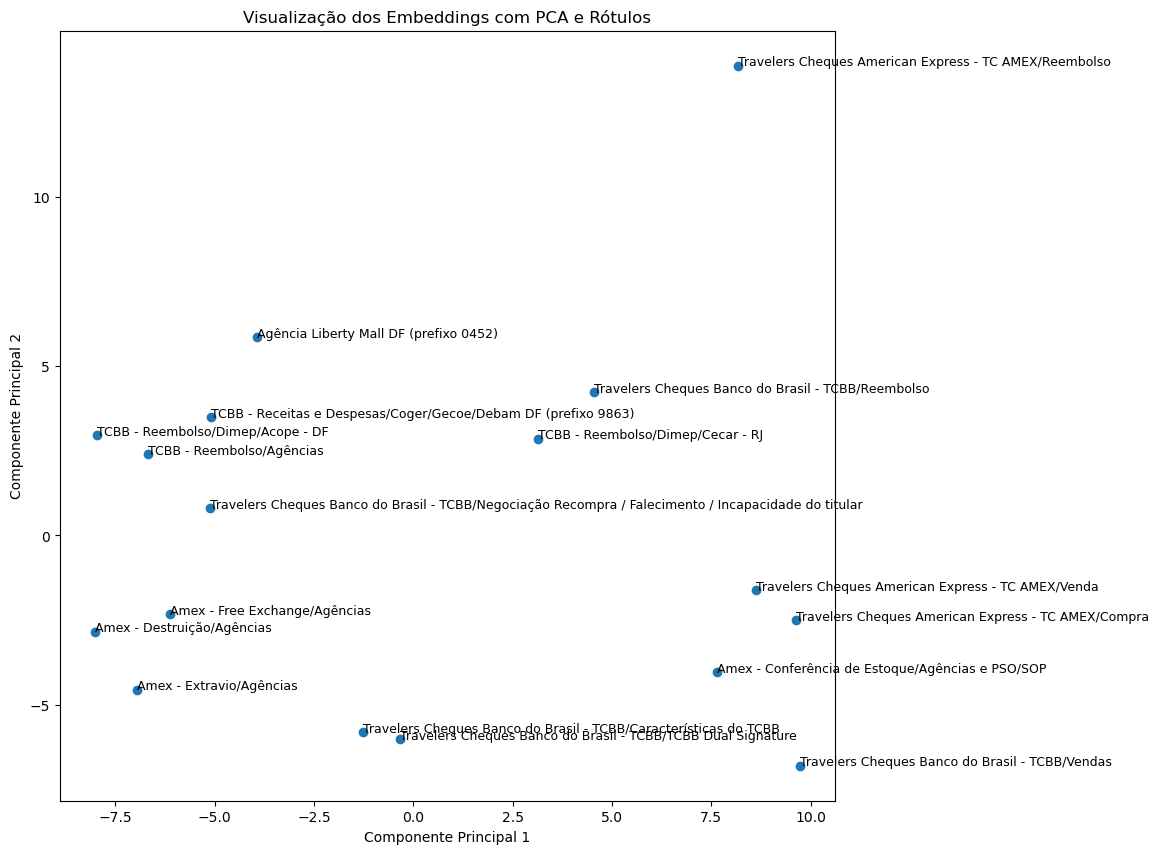

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com PCA e Rótulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")


Text(0, 0.5, 'Componente Principal 2')

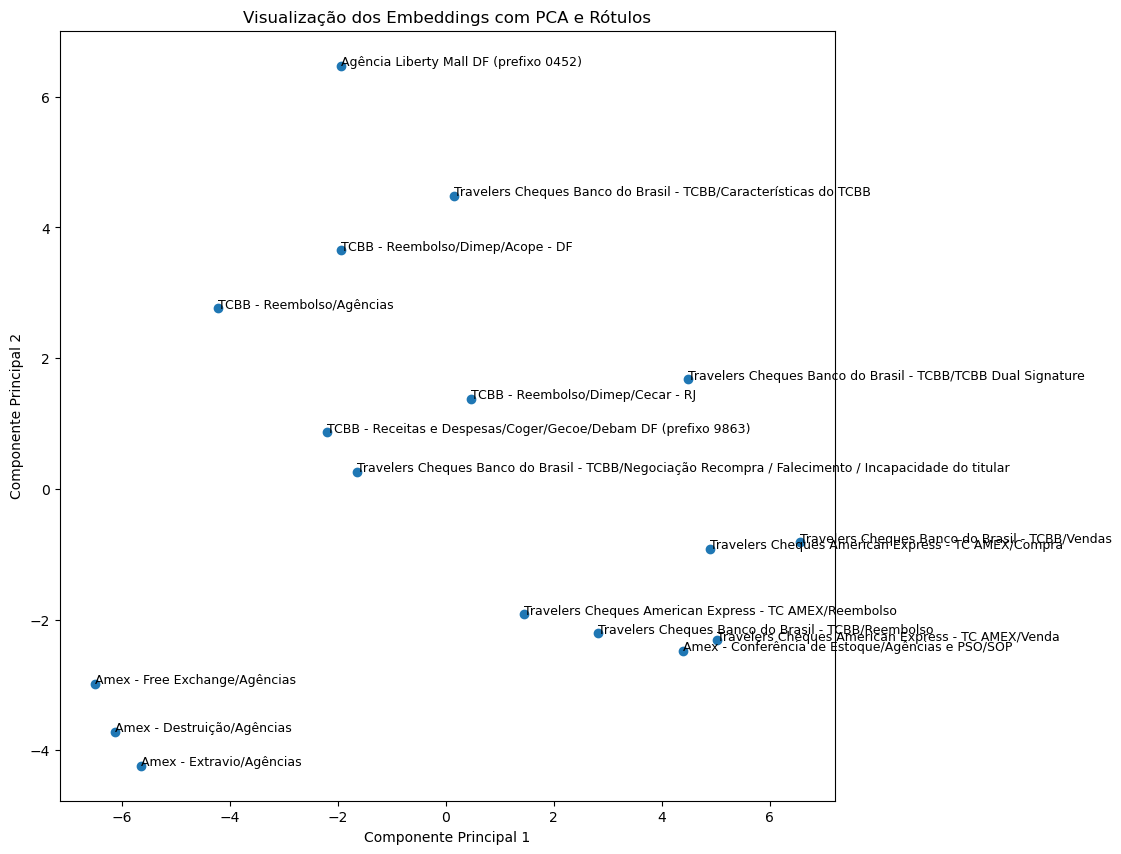

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com PCA e Rótulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")


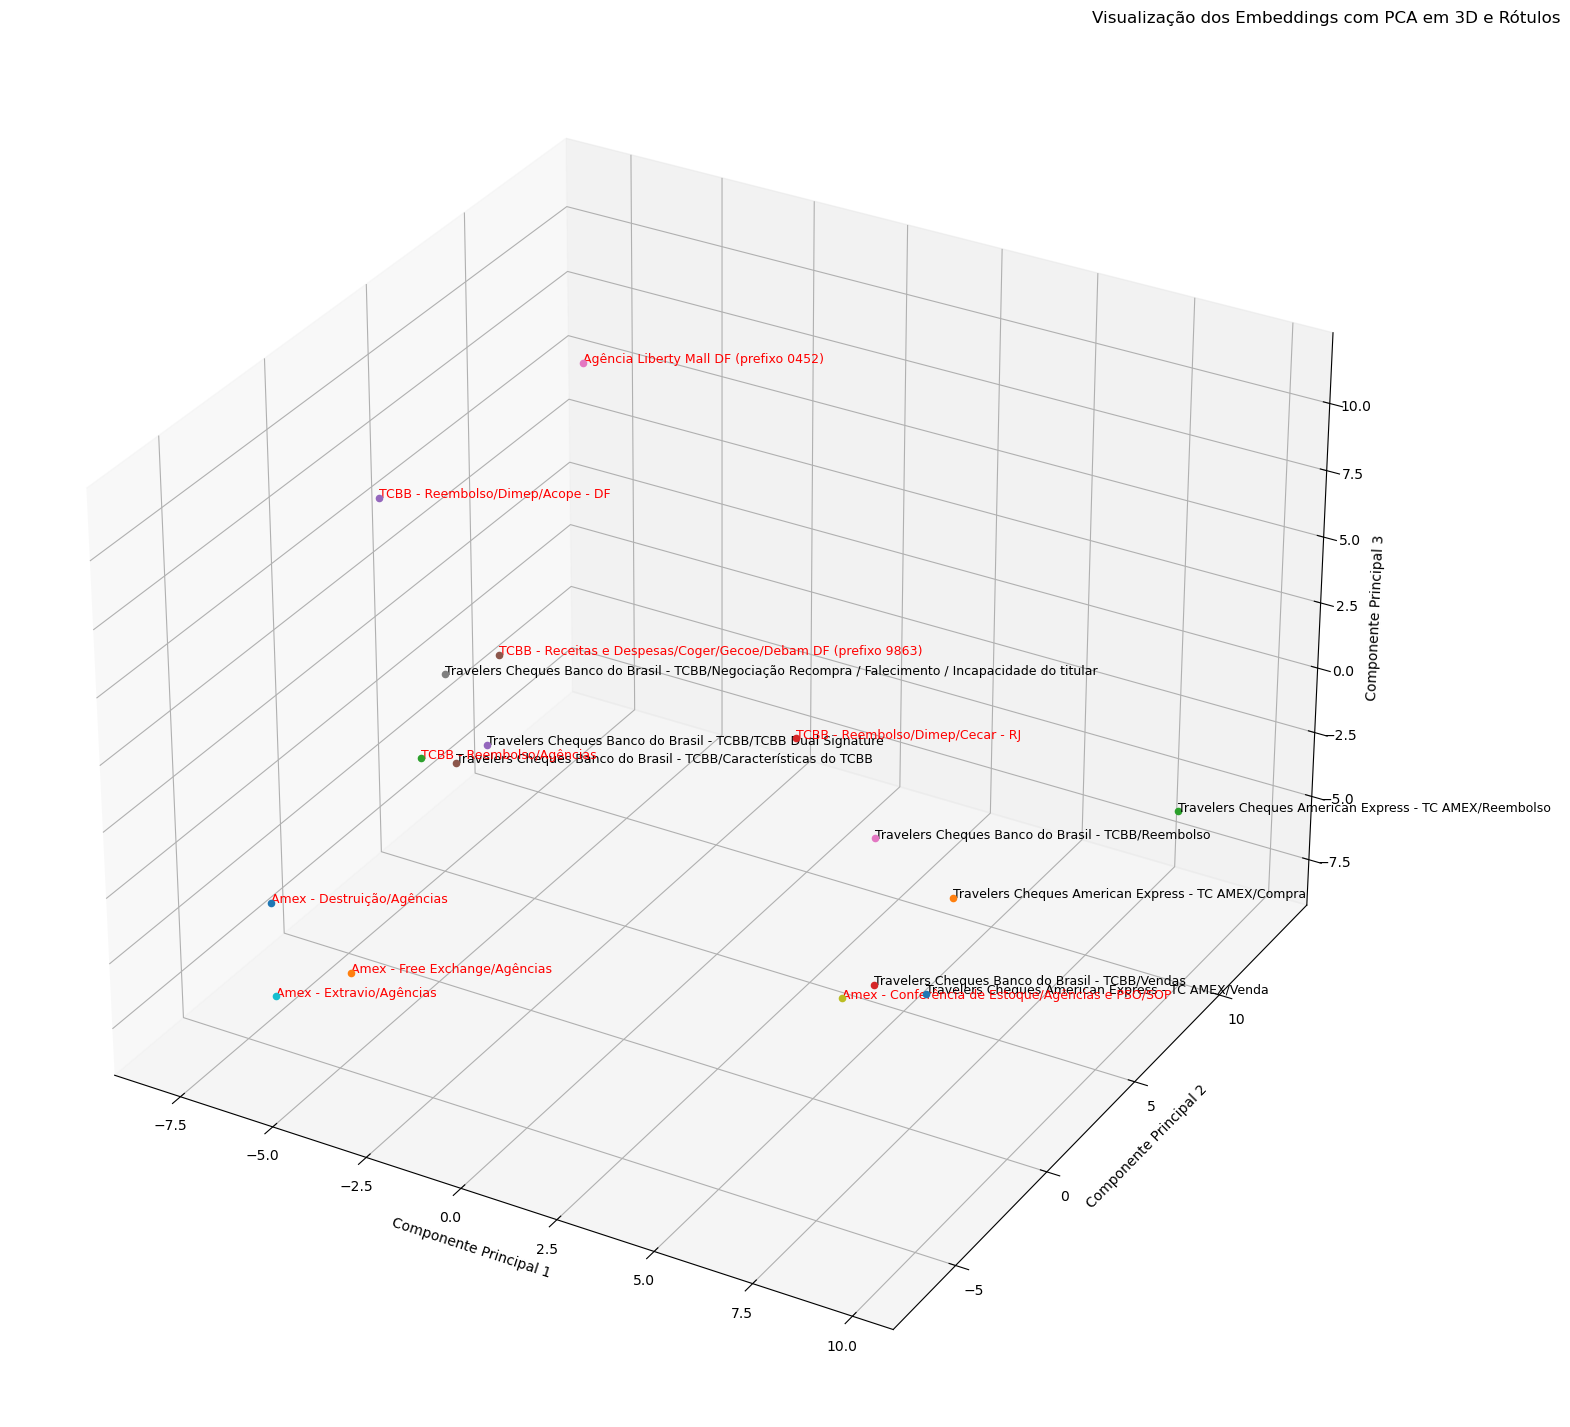

In [43]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

# Aplicar PCA para 3 componentes principais
pca = PCA(n_components=3)
embeddings_3d_pca = pca.fit_transform(flattened_embeddings)

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Iterar sobre os embeddings
for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i >= len(labels) - 9:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], color='red', fontsize=9)
    else:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([0.95, 0.2])


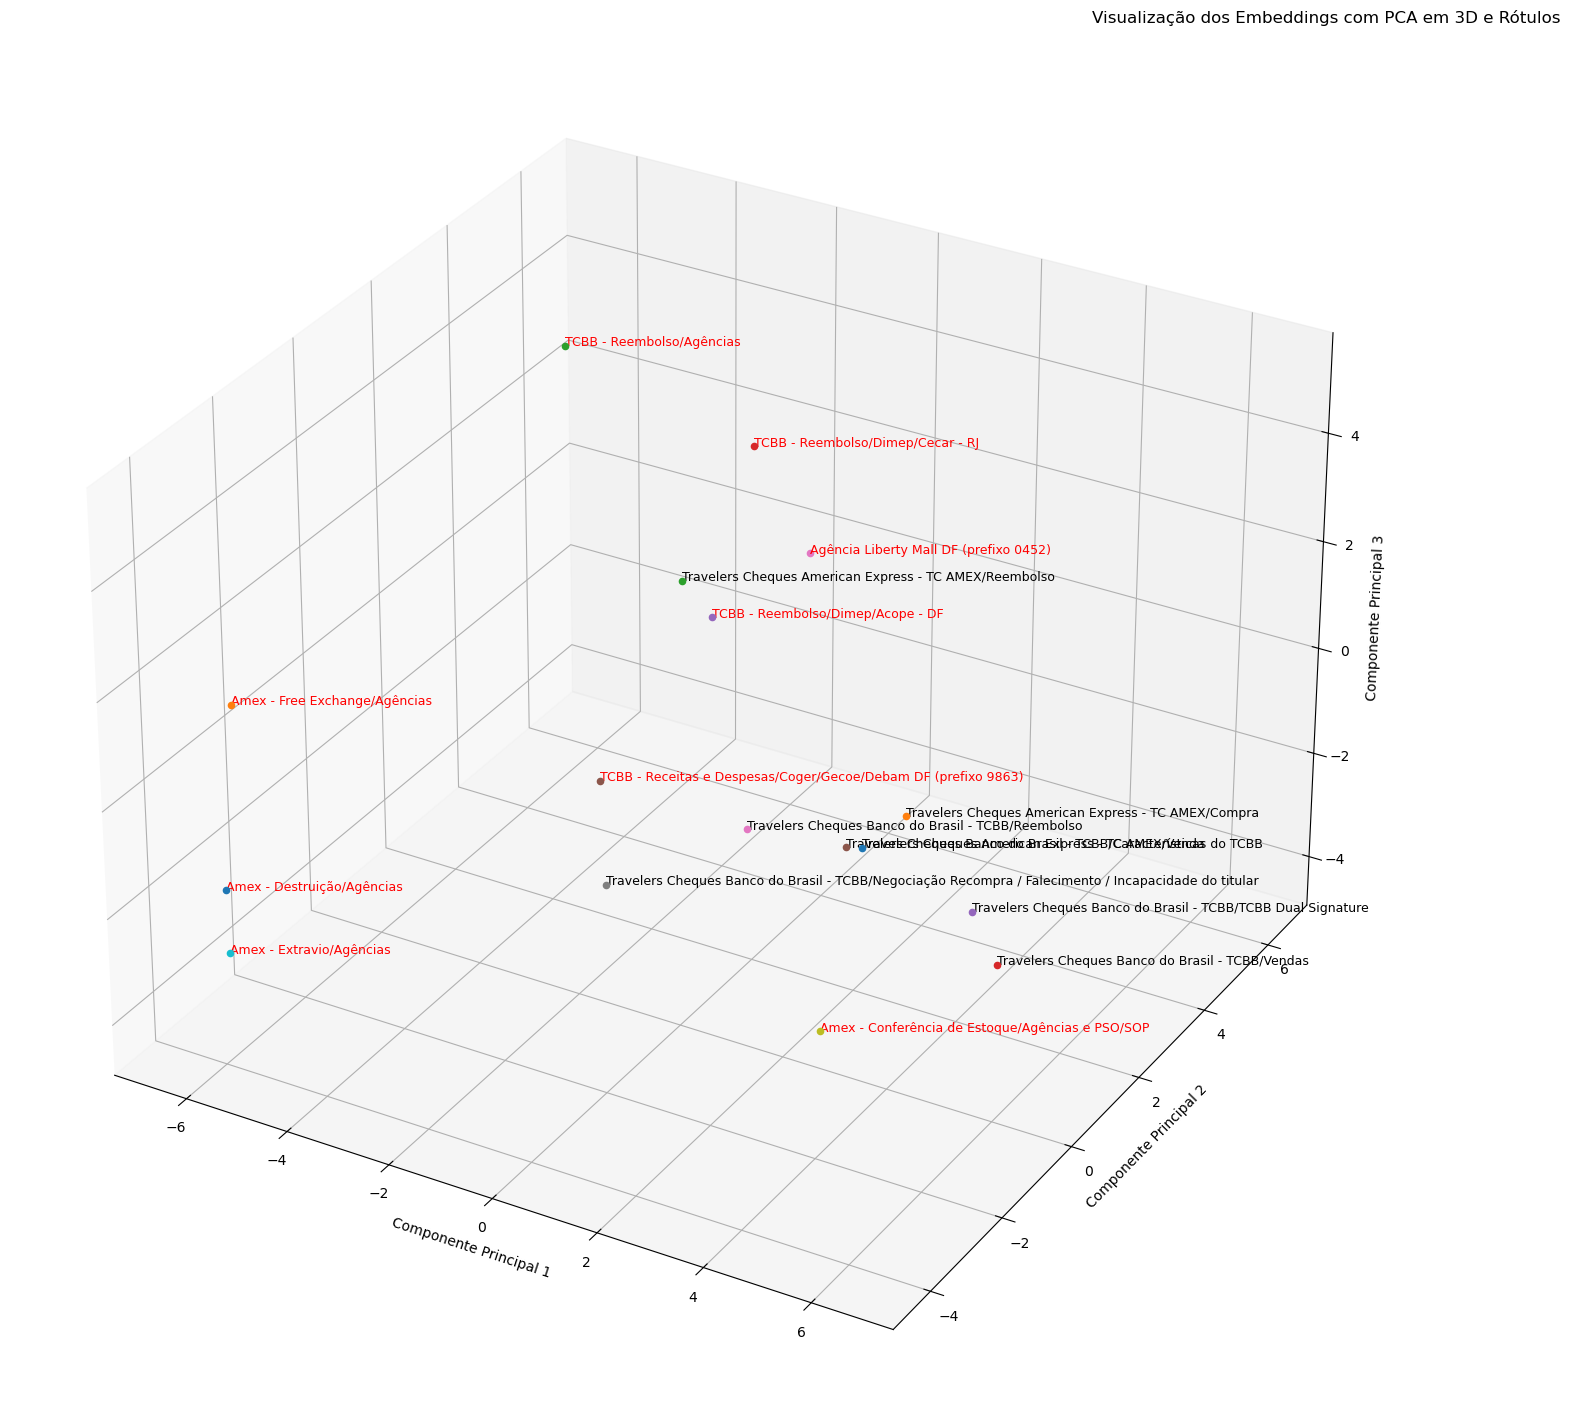

In [17]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

# Aplicar PCA para 3 componentes principais
pca = PCA(n_components=3)
embeddings_3d_pca = pca.fit_transform(flattened_embeddings)

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Iterar sobre os embeddings
for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i >= len(labels) - 9:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], color='red', fontsize=9)
    else:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([0.95, 0.2])


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular a similaridade de cosseno entre os embeddings do PCA
similarity_matrix_pca = cosine_similarity(embeddings_3d_pca)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno (PCA):")
print(similarity_matrix_pca)


Matriz de Similaridade de Cosseno (PCA):
[[ 1.          0.9703358   0.5856757   0.8660071   0.50482553 -0.42881092
   0.9750964  -0.6619546   0.8050162  -0.51387095 -0.585935   -0.5949155
  -0.5214419   0.19225042 -0.7701997  -0.9464448  -0.65316767]
 [ 0.9703358   1.0000001   0.49427843  0.9230549   0.6573785  -0.23800099
   0.89255476 -0.6539247   0.77965117 -0.69019973 -0.75739497 -0.76572025
  -0.50416875  0.22407895 -0.607622   -0.91957843 -0.45710903]
 [ 0.5856757   0.49427843  0.9999999   0.12880737 -0.30282506 -0.8691697
   0.64046687 -0.9343613   0.02815294 -0.3050162  -0.26593363  0.03742088
   0.3326764   0.79227984 -0.42563477 -0.79505664 -0.457566  ]
 [ 0.8660071   0.9230549   0.12880737  0.99999994  0.8619933   0.07140054
   0.7678281  -0.3169856   0.9113195  -0.59636724 -0.69607776 -0.853462
  -0.76008964 -0.13364787 -0.5675325  -0.7036459  -0.3877995 ]
 [ 0.50482553  0.6573785  -0.30282506  0.8619933   0.9999999   0.56317353
   0.33756587  0.01760094  0.70750046 -0.6393

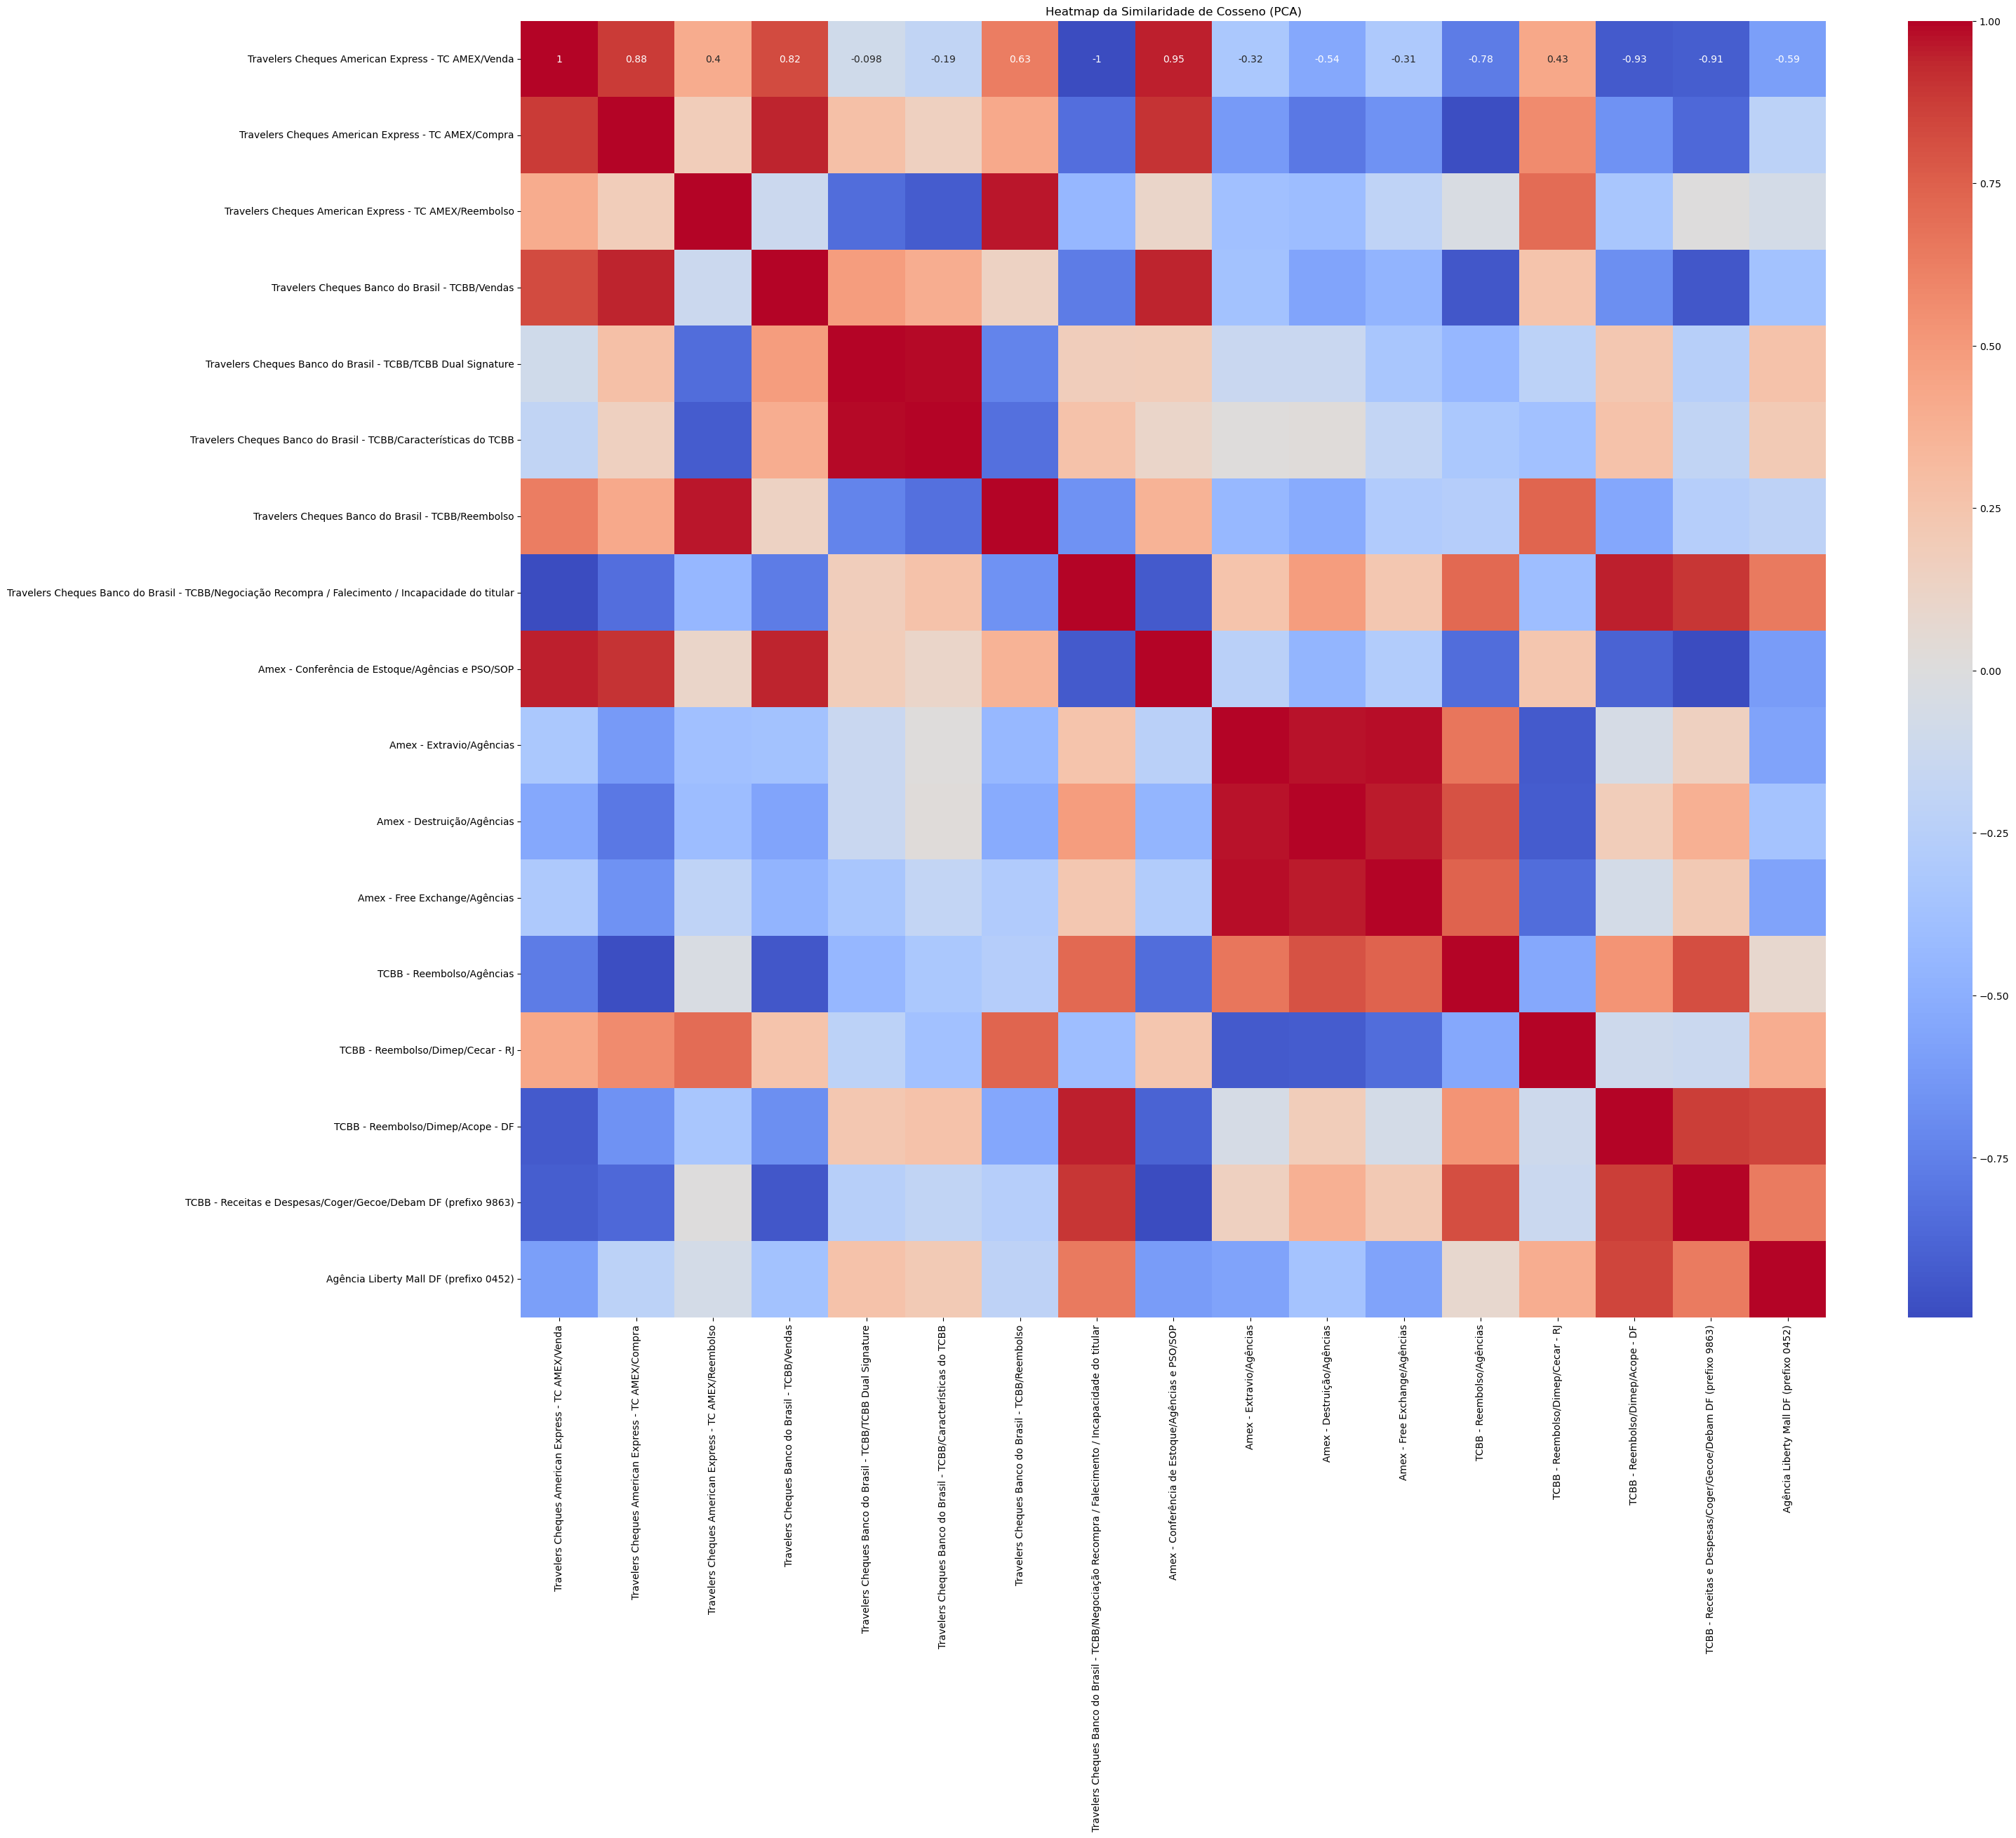

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Heatmap da matriz de similaridade de cosseno para os embeddings do PCA
plt.figure(figsize=(30, 24))
sns.heatmap(similarity_matrix_pca, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno (PCA)");


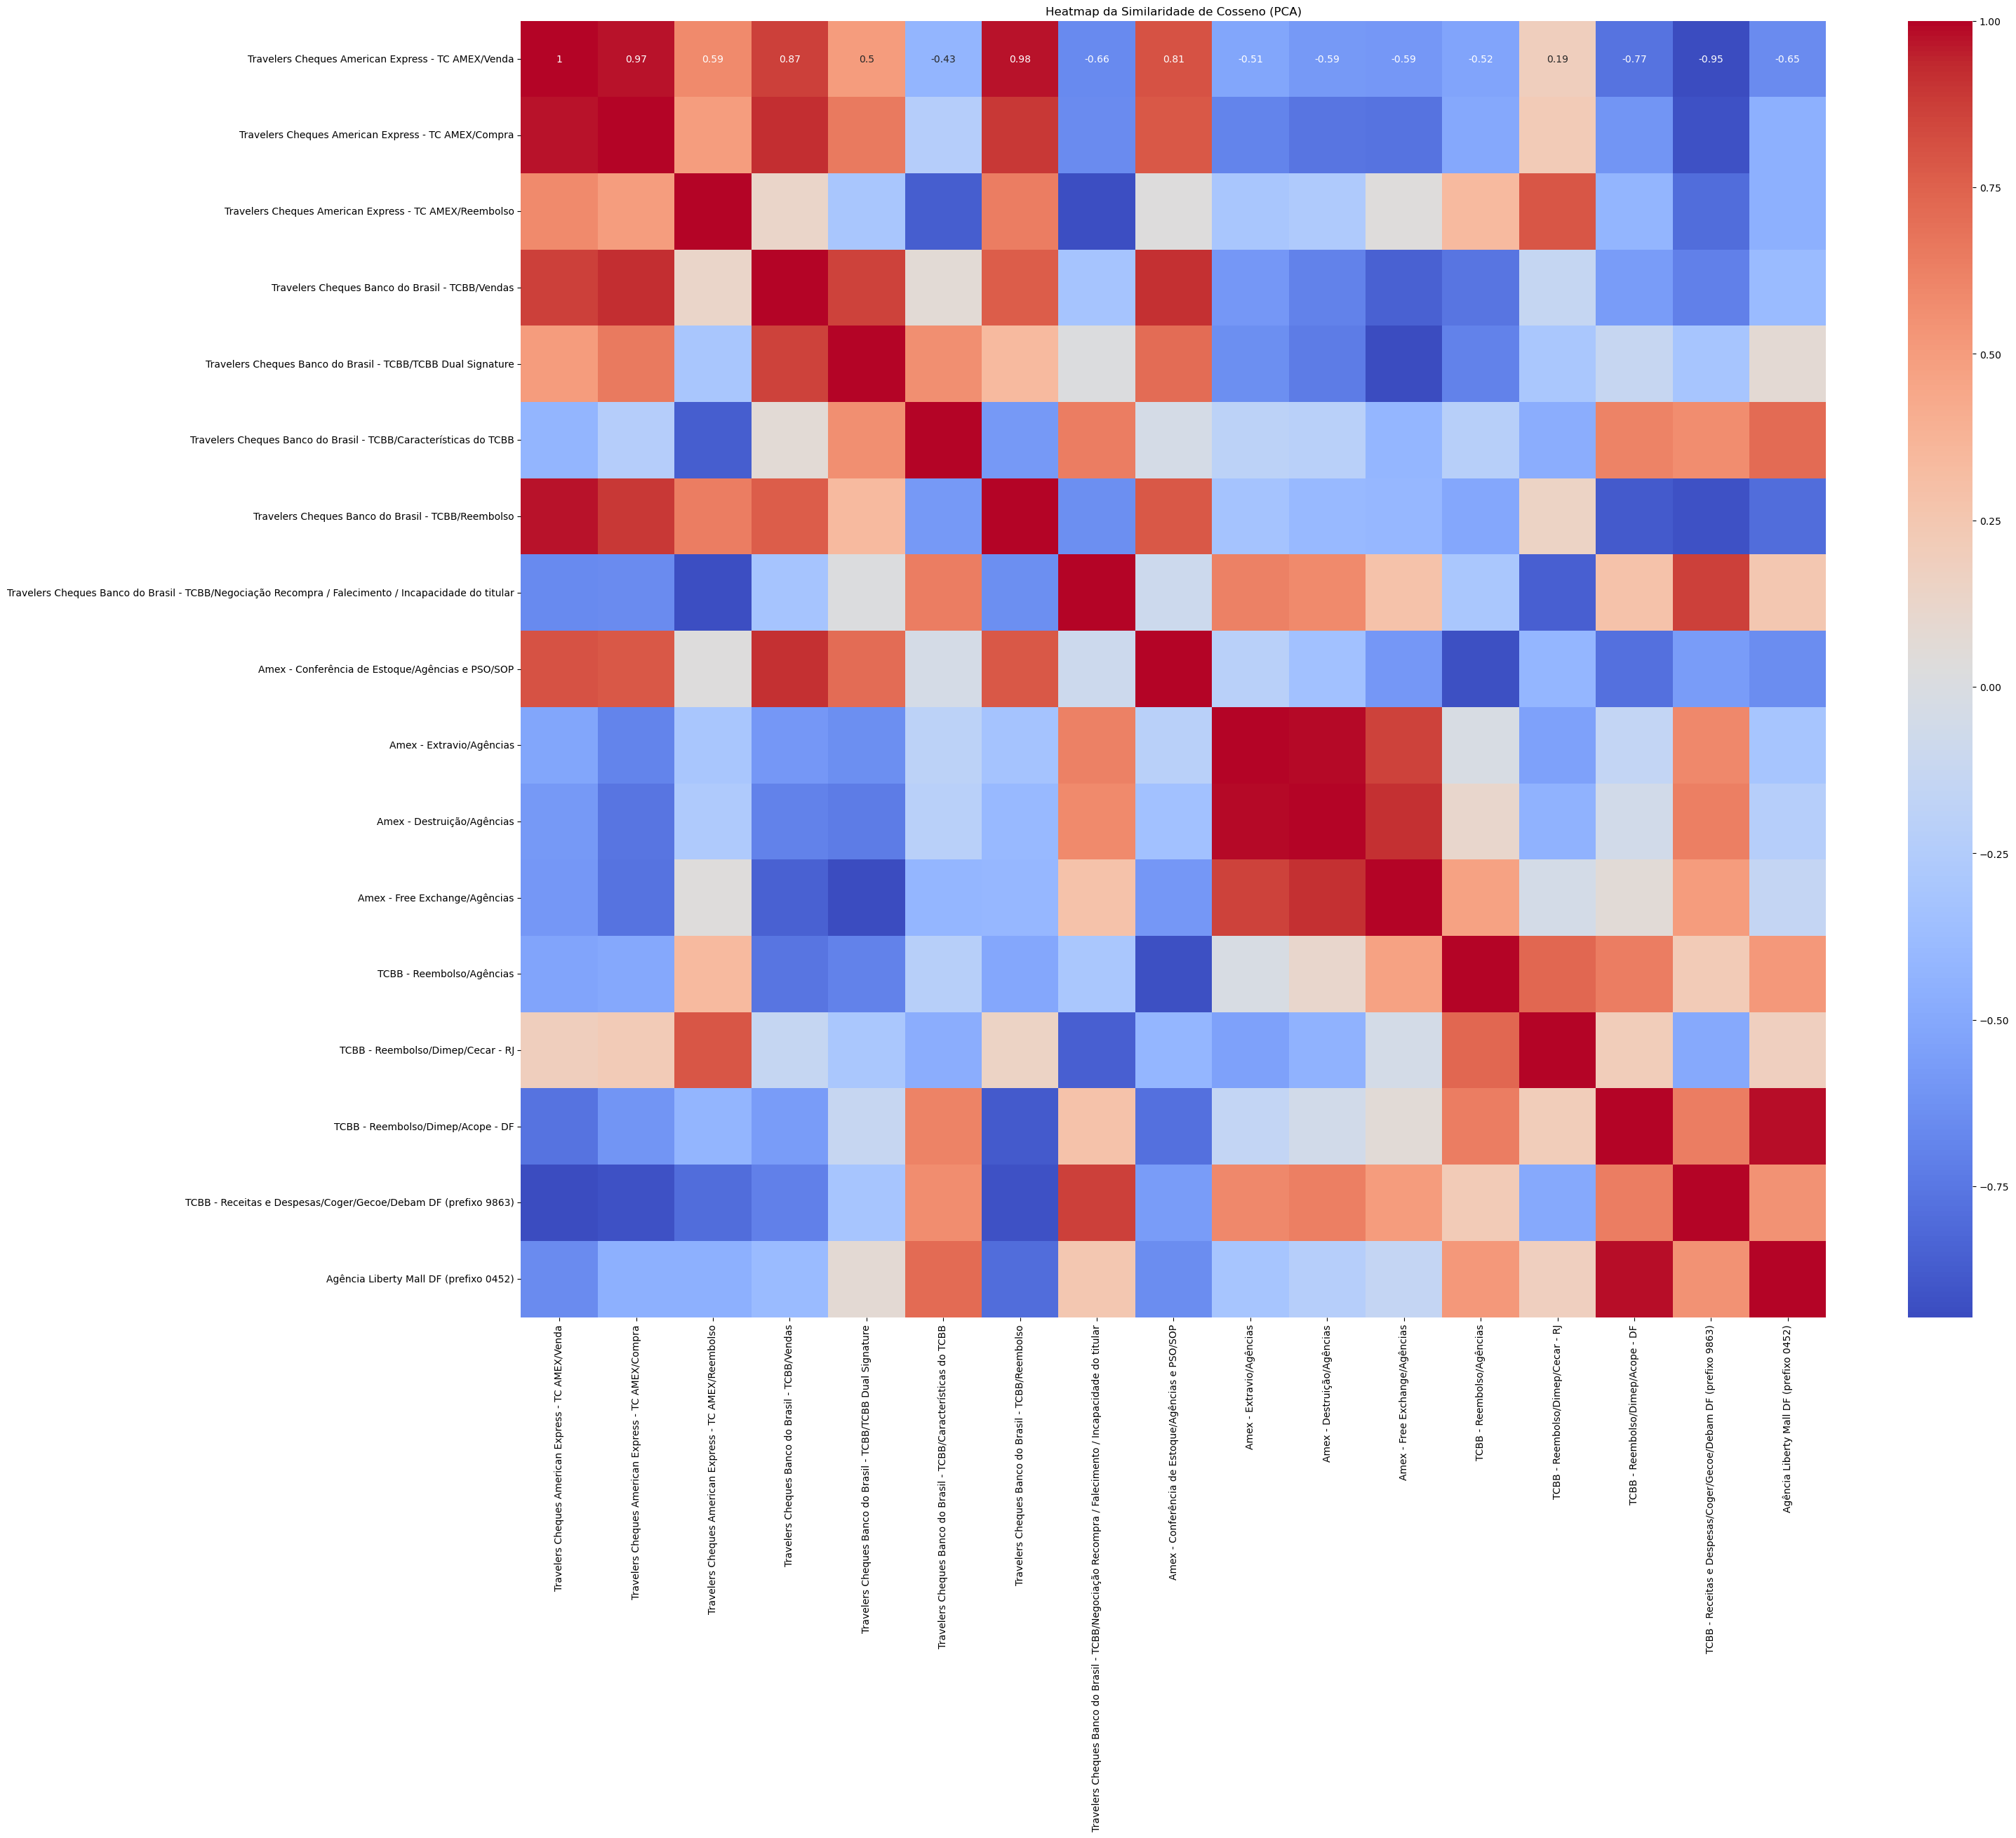

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Heatmap da matriz de similaridade de cosseno para os embeddings do PCA
plt.figure(figsize=(30, 24))
sns.heatmap(similarity_matrix_pca, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno (PCA)");
